In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

In [245]:
def below_platform(t, y, *args):
    depth = tide_spline(t) - (y[1] + depth_cutoff)
    return depth

below_platform.terminal = True
below_platform.direction = -1

def solve_ode(t, y, *args):

    # set initial values for concentration and elevation
    init_conc = y[0]
    init_elev = y[1]

    # use spline function for tide height to set current water_height
    water_height = tide_spline(t)
    depth = water_height - init_elev #calculate current depth

    # use derivative of tide spline to get current gradient and set H
    dhdt = tide_spline_deriv(t)

    if dhdt > 0:
        H = 1
    else:
        H = 0

    delta_conc = - (settle_rate * init_conc) / depth - H / depth * (init_conc - bound_conc) * dhdt
    delta_elev = settle_rate * (init_conc + delta_conc) / bulk_dens

    return [delta_conc, delta_elev]

In [260]:
dt = 60
length = 12.27 * 60 * 60
amp = 2.0
freq = 2 * np.pi / length
t = np.arange(0, length, dt)
h = amp * np.sin(freq * t)

In [261]:
h_subset = h[h > 0]
t_subset = t[h > 0]
#t_subset = np.arange(0, len(h_subset))
tide_spline = InterpolatedUnivariateSpline(t_subset, h_subset)
tide_spline_deriv = tide_spline.derivative()

In [262]:
settle_rate = 0.0011
bound_conc = 0.8
bulk_dens = 1100
depth_cutoff = 0.001

In [263]:
t_span = [t_subset[0], t_subset[-1]]
init_vals = [0, 0]
result = solve_ivp(fun=solve_ode, t_span=t_span, y0=init_vals, events=below_platform, args=(bound_conc, settle_rate, bulk_dens, depth_cutoff, dt))

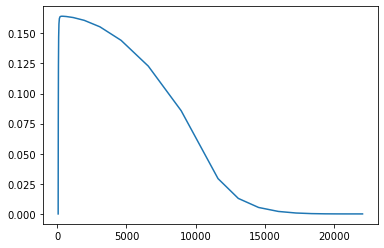

In [264]:
plt.plot(result.t, result.y[0])